<a href="https://colab.research.google.com/github/vjacobsen/Liquor-Sales-Inventory-Forecast/blob/main/Liquor_Safety_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety Stock Calculation

The approach used considers forecast error as the only factor requiring buffer inventory. 

Also, forecast error is assumed to be normally distributed.

In a real world scenario, additional variables such as supplier lead time would also need to be added.

In [123]:
import os
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import datetime 


## Optional: Enable data table display
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


#### Query
This is the forecast table loaded to Google Cloud in the previous notebook

In [124]:
### Provide your credentials to the runtime
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
print('Authenticated')

project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Construct a BigQuery client object
client = bigquery.Client(project = project_id,)

Authenticated


In [125]:
# Run query for forecast dataset
forecasts_query = client.query('''

  SELECT * FROM `iowa-liquor-sales-266301.forecasting.ml_forecasts`

''').to_dataframe()

In [126]:
forecasts_query.head()

,forecast_key,week_date,forecast,mape,best_model,trim_date,type,week_end_date,date,is_holiday,day_of_week,sales_bottles,item_number,category_name,item_description,vendor_number,month_year,year,safety_stock,holding_cost
0,10008,2019-02-10,53.0,0.13,KNN,2020-06-21,train,2019-02-10,2019-02-04,0,0,48.0,10008,Scotch Whiskies,Scoresby Rare Scotch,421,2_2019,2019,258.0,0.788
1,10008,2019-02-17,55.0,0.13,KNN,2020-06-21,train,2019-02-17,2019-02-11,0,0,72.0,10008,Scotch Whiskies,Scoresby Rare Scotch,421,2_2019,2019,258.0,0.788
2,10008,2019-02-24,54.0,0.13,KNN,2020-06-21,train,2019-02-24,2019-02-18,1,0,54.0,10008,Scotch Whiskies,Scoresby Rare Scotch,421,2_2019,2019,258.0,0.788
3,10008,2019-03-03,65.0,0.13,KNN,2020-06-21,train,2019-03-03,2019-02-25,0,0,52.0,10008,Scotch Whiskies,Scoresby Rare Scotch,421,2_2019,2019,258.0,0.788
4,10008,2019-03-10,65.0,0.13,KNN,2020-06-21,train,2019-03-10,2019-03-04,0,0,29.0,10008,Scotch Whiskies,Scoresby Rare Scotch,421,3_2019,2019,258.0,0.788


## Transform data

Data is grouped by month-year and forecast error is calulated at this level

In [127]:
forecasts = forecasts_query.copy()

# Convert string to date
forecasts['date'] = pd.to_datetime(forecasts_query['date'])

# Convert key number to str
forecasts['forecast_key'] = forecasts['forecast_key'].astype(str)

# Group by month-year
forecasts['month_year'] = forecasts['date'].dt.month.astype(str) +  "_" + forecasts['date'].dt.year.astype(str)
forecasts['year'] = forecasts['date'].dt.year.astype(str)

monthly_forecasts = forecasts.groupby(['forecast_key','month_year','type','year']).agg({"sales_bottles":sum,"forecast":sum,"date":max}).reset_index()
monthly_forecasts.rename(columns={'date':'month_end'},inplace=True)

# Historical only
historical = monthly_forecasts[monthly_forecasts['type']!='forecast'] 

# Future forecast only
forecasts_weekly = forecasts[forecasts['type']=='forecast'] 
monthly_forecasts = monthly_forecasts[monthly_forecasts['type']=='forecast'] 

target_value = 'sales_bottles'

historical['error'] = historical['forecast'] - historical[target_value]  # Error
historical.head()

,forecast_key,month_year,type,year,sales_bottles,forecast,month_end,error
0,100015,10_2017,train,2017,291.0,171.0,2017-10-31,-120.0
1,100015,10_2018,train,2018,188.0,174.0,2018-10-31,-14.0
2,100015,10_2019,train,2019,0.0,153.0,2019-10-31,153.0
4,100015,10_2020,test,2020,93.0,135.0,2020-10-25,42.0
6,100015,11_2017,train,2017,136.0,75.0,2017-11-30,-61.0


## Inventory Optimization


### Historical Error distribution
Look at percetage error to allow for better comparison between items

In [128]:
# Calculate MAPE
historical['mape_pcnt'] = (np.divide(historical['error'],historical['sales_bottles']).abs()).round(2)

# Infinite MAPE values are generated when error is 0, replace with 0
non_infinite_mask = ~historical['mape_pcnt'].isin([np.inf,-np.inf])

historical['mape_pcnt'] = historical['mape_pcnt'].where(non_infinite_mask,other=0)

# Summary
historical.describe().round(2)

,sales_bottles,forecast,error,mape_pcnt
count,5924.00,5924.00,5924.00,5499.00
mean,2327.72,2286.00,-41.72,0.41
std,11301.21,11212.37,969.62,3.43
min,0.00,-517.00,-17425.00,0.00
25%,69.00,80.00,-56.00,0.05
50%,338.00,340.00,0.00,0.14
75%,1234.00,1158.50,52.00,0.34
max,186832.00,187566.00,11955.00,175.17


Looking at the summary table, we notice some extreme error values

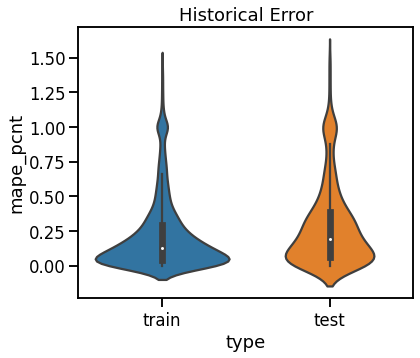


 118 item-months have error above 150%

 They represent 2.0% of total items-month keys


In [129]:
# Violin plot without extreme values
sns.set_context('talk')
data = historical[historical['mape_pcnt']<1.5]
plt.figure(figsize=(6,5))
plt.title('Historical Error')
sns.violinplot(x=data['type'],y=data['mape_pcnt'])
plt.show()

# How many item - months have MAPE error above 150%?
print("\n {} item-months have error above 150%".format(len(historical[historical['mape_pcnt']>1.5])))

percent_of_total =  (len(historical[historical['mape_pcnt']>1.5])/len(historical))*100
print("\n They represent {}% of total items-month keys".format(round(percent_of_total,1)))

### Reorder Quantity

We'll use the Minimum Order Quantity formula:

$ EOQ = \sqrt{2 *\dfrac{Annual \ Demand * Cost \ per \ Order}{Annual \ Holding \ Cost \ per \ Unit}} $


* Annual holding cost is set at 15% of the bottle's cost
* The bottle cost is 60% of the retail value  


It is known that the main limitation against the use of this formula is that demand needs to be constant throughout time, which is not the case for this project but the formula is still used for simplicity.

We must first get the average bottle price by querying the sales data in the last year

#### Bottle price - query

In [130]:
item_price = client.query('''

  SELECT 
    item_number,
    item_description,
    category_name, 
    SUM(sale_dollars)/SUM(bottles_sold) as avg_price
  FROM 
    `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE 
    date > DATE_SUB((SELECT MAX(date) FROM `bigquery-public-data.iowa_liquor_sales.sales`), INTERVAL 1 YEAR) AND 
    vendor_number = '421'
  GROUP BY
    item_number, 
    category_name, 
    item_description

''').to_dataframe()

# Create dictionary to aid in lookup
item_price_dict = item_price.set_index('item_number')['avg_price'].to_dict()
item_price.sample(3)

,item_number,item_description,category_name,avg_price
282,903563,Rain Vodka,Special Order Items,11.25
263,920186,Weller Full Proof Barrel,Straight Bourbon Whiskies,37.50
168,69658,Dr McGillicuddys Mentholmint,Imported Schnapps,21.99


We are looking to calculate the reorder quantity for the next year. To do that, first we query the data to include only the next year's forecasts.


#### Annual demand by item

In [131]:
# Annual demand by key query
year_forecast = client.query('''

  SELECT 
    forecast_key,
    SUM(forecast) as annual_forecast
  FROM 
    `iowa-liquor-sales-266301.forecasting.ml_forecasts`
  WHERE
    type = 'forecast'
  GROUP BY
    forecast_key

''').to_dataframe()

year_forecast['forecast_key']  = year_forecast['forecast_key'].astype(str)
year_forecast.head()

,forecast_key,annual_forecast
0,10008,17265.0
1,10009,2330.0
2,37418,15805.0
3,43648,2260.0
4,66636,11250.0


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


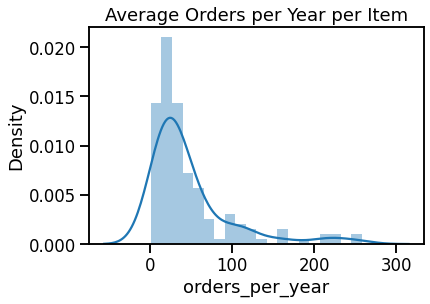

,forecast_key,annual_forecast,item_price,item_cost,holding_cost_unit,economic_order_qty,orders_per_year
0,10008,17265.0,15.75,6.300,1.8900,234.0,73.782051
1,10009,2330.0,10.11,4.044,1.2132,107.0,21.775701
2,37418,15805.0,12.75,5.100,1.5300,249.0,63.473896
3,43648,2260.0,10.82,4.328,1.2984,102.0,22.156863
4,66636,11250.0,20.25,8.100,2.4300,167.0,67.365269


In [132]:
# Set up variables
unit_cost_pcnt = 0.4 # direct unit cost, as percent of item price
holding_cost = 0.3 # as percent of item cost - per year.
cost_per_order = 3 # dollars

# Calculated columns
year_forecast['item_price'] =  [round(item_price_dict.get(key),2) for key in year_forecast['forecast_key']] # lookup price
year_forecast['item_cost'] = year_forecast['item_price'] * unit_cost_pcnt
year_forecast['holding_cost_unit'] = year_forecast['item_cost'] * holding_cost

# Now it's possible to calculate the economic order quantity
year_forecast['economic_order_qty'] = np.sqrt(2*(cost_per_order*year_forecast['annual_forecast'])\
                                                /year_forecast['holding_cost_unit']).round(0)

year_forecast['orders_per_year'] = year_forecast['annual_forecast']/year_forecast['economic_order_qty']

# Plot
plt.title('Average Orders per Year per Item')
sns.distplot(year_forecast['orders_per_year'])
plt.show()

year_forecast.head()

As we can see, some items have extreme supplier order frequency suggested that averages more than one order per week, something is rarely feasible for the item type, at a distributor level. However, this is expected since the formula used doesn't take into account many other factors (demand variability, minimum order quantities, truckload utilization, etc...)

We'll set a rule that caps the orders per year at a maximum of 16:

In [133]:
max_orders_per_year = 16

# Replace values above 16
year_forecast['orders_per_year'] = year_forecast['orders_per_year'].where(year_forecast['orders_per_year']<16,16)

# Calculate actual order quantity
year_forecast['actual_order_qty'] = (year_forecast['annual_forecast']/year_forecast['orders_per_year']).round(0)

# Create lookup dictionaries for future use
item_holding_cost_dict = year_forecast.set_index('forecast_key')['holding_cost_unit'].to_dict()
oq_dict = year_forecast.set_index('forecast_key')['actual_order_qty'].to_dict()

year_forecast.head()

,forecast_key,annual_forecast,item_price,item_cost,holding_cost_unit,economic_order_qty,orders_per_year,actual_order_qty
0,10008,17265.0,15.75,6.300,1.8900,234.0,16.0,1079.0
1,10009,2330.0,10.11,4.044,1.2132,107.0,16.0,146.0
2,37418,15805.0,12.75,5.100,1.5300,249.0,16.0,988.0
3,43648,2260.0,10.82,4.328,1.2984,102.0,16.0,141.0
4,66636,11250.0,20.25,8.100,2.4300,167.0,16.0,703.0


### Reorder Point

$ Reorder Point = Lead \ Time \ Demand + Safety \ Stock $

Lead time demand will be different for each month due to demand fluctuation.

<br>

First, we'll calculate the average lead time demand throughout the year:

In [134]:
# Calculate mean lead time demand (will be used with safety stock later on)
mean_lead_time_demand = monthly_forecasts.groupby('forecast_key')['forecast'].mean()
mean_lead_time_demand.rename('mean_lt_demand',inplace=True)
lt_demand_dict = mean_lead_time_demand.to_dict()

# Join to main dataset
year_forecast = year_forecast.set_index('forecast_key').join(mean_lead_time_demand).reset_index()

# Remaining inventroy cost calculated from yearly dataset. Divided by two to average across periods. Exclude safety stock
year_forecast['lt_stock_cost'] = (year_forecast['mean_lt_demand']*year_forecast['holding_cost_unit'])/2
year_forecast['oq_stock_cost'] = (year_forecast['actual_order_qty']*year_forecast['holding_cost_unit'])/2

year_forecast.head()

,forecast_key,annual_forecast,item_price,item_cost,holding_cost_unit,economic_order_qty,orders_per_year,actual_order_qty,mean_lt_demand,lt_stock_cost,oq_stock_cost
0,10008,17265.0,15.75,6.300,1.8900,234.0,16.0,1079.0,1328.076923,1255.032692,1019.6550
1,10009,2330.0,10.11,4.044,1.2132,107.0,16.0,146.0,179.230769,108.721385,88.5636
2,37418,15805.0,12.75,5.100,1.5300,249.0,16.0,988.0,1215.769231,930.063462,755.8200
3,43648,2260.0,10.82,4.328,1.2984,102.0,16.0,141.0,173.846154,112.860923,91.5372
4,66636,11250.0,20.25,8.100,2.4300,167.0,16.0,703.0,865.384615,1051.442308,854.1450


### Optimize Safety Stock



We'll optimize safety stock by minimizing the cost function defined as:

> $C(x) = SS(sl) \times IC + LS$

Where:

* _SS: Total safety stock for all items, a function of the service level (sl)_   
* _IC: Inventory holding cost (year)_  
* _LS: Lost sales estimate for the period (year)_  

  
---

<br>


**Calculating Safety Stock with Demand Uncertainty**

The calculation of the safety stock itself will consider the normal deviation of **demand forecast error** during lead time. 

The service level is defined as the percentage of the **time spent in stock** over a total period equal to the lead time.

For simplicity purposes, the **lead time is assumed to be one month** for all items. If lead time was different, then forecast error would have to be measured across the lead time.

Some safety stock formulas are calculated based on average demand during lead time. However, this will lead to extreme inventories since it will assume demand forecast is the mean of historical observations. Since we can explain some variation in the data by causal factors through forecasting, the forecast error is incorporated into the safety stock calculation. 

Safety stock forumla given by:

> $ SS = Z \times ∂F_{error} $

Where:   
* Z - Inverse probability function  
* $∂F_{error}$ - Standard deviation of forecast error **during lead time**

_Note: ideally the forecast error should be taken from actuals vs forecast. However, we don't have actual forecasts to compare the model to, so we'll use the test error deviation._

Source: https://www.lokad.com/calculate-safety-stocks-with-sales-forecasting


---

<br>


**Calculating Lost Sales**


The serivce level in this case essentialy indicates the percentage of replenishment cycles that the warehouse will remain in stock for a given item during lead time. We can estimate the lost sales. If an item is ordered 100 times during the year, a service level of 95% indicates an out of stock occurence will happen 5 times.  

If the lead time is one month, then the item is at risk of running out of stock due to unforeseen demand at any point during the 30 day lead time period. Since inventory is usually high at the beginning of the lead time period, out of stocks will tend to occur in later days.  

For this project it is assumed that, on average, an out of stock result in lost sales equal to the forecast error in value. 

Lost sales can then be estimate by: 

> $LS = (1-sl) \times OrdersPerYear \times MAD_{forecast} \times Unit Value$

Where:  
* sl - Service level 
* MAD - Mean absolute deviation of the forecast error

Source: https://www.lokad.com/service-level-definition-and-formula

In [135]:
# First, we calculate the profit value of the mean forecast error
# (how much the distributor would have expected to sell in a stockout period)

profit_margin = .15
mad_by_key = historical.groupby('forecast_key')['error'].apply(lambda x: np.mean(abs(x)))
key_value = [item_price_dict.get(key) for key in mad_by_key.index]
mad_profit_value = pd.DataFrame(mad_by_key * key_value * profit_margin)
mad_profit_value = mad_profit_value.join(year_forecast.set_index('forecast_key')['orders_per_year']) 

# Next, the average number of orders per year is used to precalculate the probability of stock out
stock_out_cost = (mad_profit_value['error'] * mad_profit_value['orders_per_year']).sum()


# Create safety stock function that will be applied to each item
def safety_stock_func(df,service_level):
    z = stats.norm.ppf(service_level) 
    std_forecast_error = np.std(df['error'])
    ss_calculation = z * std_forecast_error

    return ss_calculation


service_levels_list = np.arange(.90,.995,.001) # values to be looped

# Initialize cost lists used to hold outputs
safety_stock_cost_list = []
lost_sales_list = []

# Calculate lost sales and inventory cost for each service level
for sl in service_levels_list:
  
  safety_stock = historical.groupby('forecast_key').apply(lambda x: safety_stock_func(x,sl))
  
  holding_cost = [item_holding_cost_dict.get(key) for key in safety_stock.index] # Lookup
  
  safety_stock_cost = sum(safety_stock*holding_cost)
  
  safety_stock_cost_list.append(safety_stock_cost)

  lost_sales = (1-sl)*stock_out_cost # estimate per year.
  
  lost_sales_list.append(lost_sales)

# Join cost data in data frame
safety_stock_cost_levels = pd.DataFrame({'lost_sales':lost_sales_list,
                                      'safety_stock_cost':safety_stock_cost_list},
                                     service_levels_list*100)

# Total cost function
safety_stock_cost_levels['total_cost'] = safety_stock_cost_levels['lost_sales'] + safety_stock_cost_levels['safety_stock_cost']

# Optimal service level
optimal_sl = safety_stock_cost_levels['total_cost'].idxmin()
optimal_sl_cost = safety_stock_cost_levels['total_cost'].min()
print('Optimal service level: {}%'.format(optimal_sl))

Optimal service level: 97.2%


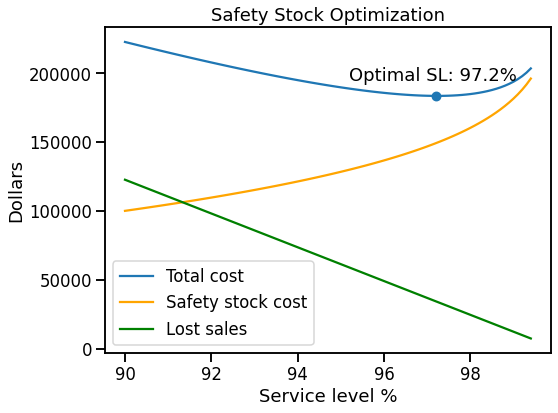

In [136]:
# We now have the lost sales estimate and inventory cost  by service level. Plotting the results:
plt.figure(figsize=(8,6))
plt.title('Safety Stock Optimization')

index = safety_stock_cost_levels.index

sns.lineplot(x=index,y=(safety_stock_cost_levels['total_cost']))
sns.lineplot(x=index,y=(safety_stock_cost_levels['safety_stock_cost']),color='orange')
sns.lineplot(x=index,y=(safety_stock_cost_levels['lost_sales']),color='green')
plt.scatter(optimal_sl, optimal_sl_cost, marker='o', s=70) # optimal point

plt.annotate('Optimal SL: {}%'.format(optimal_sl), 
             xy=(optimal_sl,optimal_sl_cost),
             xytext=(optimal_sl-2, (optimal_sl_cost)+11000)
             )

plt.legend(['Total cost','Safety stock cost','Lost sales'])
plt.ylabel('Dollars')
plt.xlabel('Service level %')
plt.show()

#### Calculate Safety Stock with optimal service level

In [137]:
# Desired service level
sl = optimal_sl/100
safety_stock = historical.groupby('forecast_key').apply(lambda x: safety_stock_func(x,sl))
safety_stock = pd.DataFrame(safety_stock,columns=['safety_stock']).round()

safety_stock['std_error'] = historical.groupby('forecast_key')['error'].apply(lambda x: np.std(x))
safety_stock.head()

,safety_stock,std_error
forecast_key,,
100015,118.0,61.610018
10006,81.0,42.369293
10008,252.0,131.672867
10009,89.0,46.772904
100413,136.0,71.396822


In [138]:
# Join other parameters
inventory_data = safety_stock.join(year_forecast.set_index('forecast_key'))
inventory_data.round(2).head()

,safety_stock,std_error,annual_forecast,item_price,item_cost,holding_cost_unit,economic_order_qty,orders_per_year,actual_order_qty,mean_lt_demand,lt_stock_cost,oq_stock_cost
forecast_key,,,,,,,,,,,,
100015,118.0,61.61,965.0,45.00,18.00,5.40,33.0,16.0,60.0,74.23,200.42,162.00
10006,81.0,42.37,3815.0,7.70,3.08,0.92,157.0,16.0,238.0,293.46,135.58,109.96
10008,252.0,131.67,17265.0,15.75,6.30,1.89,234.0,16.0,1079.0,1328.08,1255.03,1019.66
10009,89.0,46.77,2330.0,10.11,4.04,1.21,107.0,16.0,146.0,179.23,108.72,88.56
100413,136.0,71.40,5520.0,90.00,36.00,10.80,55.0,16.0,345.0,424.62,2292.92,1863.00


In [149]:
# Subset to columns not in Big Query table
forecasts = forecasts[forecasts.columns[~forecasts.columns.isin(inventory_data.columns)]]

# Join safety stock data to dataset
inventory_data = forecasts.set_index("forecast_key").join(inventory_data[['safety_stock']])

print('\n SS Calcualted! \n Median SS: \n {}'.format(round(inventory_data['safety_stock'].median())) )


 SS Calcualted! 
 Median SS: 
 174


### Plot

Number of Obs: 49


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


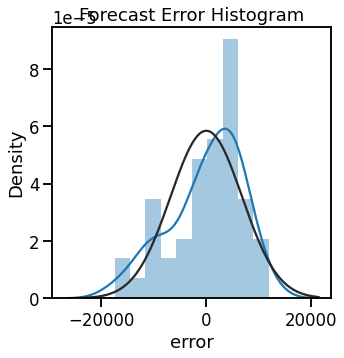

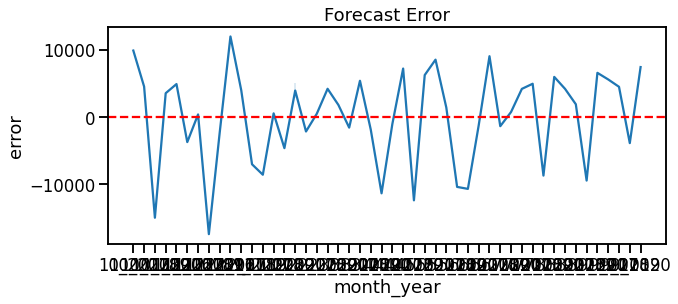

In [159]:
from scipy.stats import norm

specific_key = '64870'

# Plot
sns.set_context('talk')
sample_dataset = historical[historical['forecast_key'].isin(historical['forecast_key']\
                                                            .drop_duplicates().sample())] # random key

sample_dataset = historical[historical['forecast_key'].isin([specific_key])]  
print('Number of Obs:',len(sample_dataset))

# Histogram
plt.figure(figsize=(5,5))
plt.title('Forecast Error Histogram')
sns.distplot(sample_dataset['error'],bins=10,fit=norm)
plt.show()

# Error plot
plt.figure(figsize=(10,4))
plt.title('Forecast Error')
sns.lineplot(y='error',x='month_year', data=sample_dataset)
plt.axhline(0, ls='--',color='red')
plt.show()

## Export to BigQuery

In [160]:
from google.cloud import bigquery

# Save table locally
inventory_data.to_csv('ss_forecasts.csv')

# Specify project and destination 
project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Local path of file to be uploaded
forecasts_path = "/content/ss_forecasts.csv"

file_paths = [forecasts_path]
table_names = ["ml_forecasts"]

# Construct a BigQuery client object
client = bigquery.Client(project = project_id)

# Batch load tables
for file_path,tb_name in zip(file_paths,table_names):
  
  table_id = "{}.{}.{}".format(project_id,bq_dataset_name,tb_name)

  job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.CSV, 
      skip_leading_rows=1, 
      autodetect=True,
  )

  job_config.write_disposition = 'WRITE_TRUNCATE' # Replace data

  with open(file_path, "rb") as source_file:
      job = client.load_table_from_file(source_file, table_id,job_config=job_config)
      
  job.result()  # Waits for the job to complete.

  table = client.get_table(table_id)  # Make an API request.

  print(
      "Loaded {} rows and {} columns to {}".format(
          table.num_rows, len(table.schema), table_id
      )
  )

Loaded 231936 rows and 20 columns to iowa-liquor-sales-266301.forecasting.ml_forecasts
